* This notebook was made to create three ferry routes shown in the map. 

In [1]:
import datetime
import glob
import os

from matplotlib.backends import backend_agg as backend
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import netCDF4 as nc
import numpy as np
import requests
import scipy.io as sio
from mpl_toolkits.basemap import Basemap

from salishsea_tools import (
    nc_tools,
    viz_tools,
    tidetools,
    geo_tools
)

from datetime import datetime, timedelta
from glob import glob
import datetime

%matplotlib inline
import sys
import scipy.io as sio

sys.path.append('/ocean/jieliu/research/meopar/salinity_comparison/')
import research_ferries as rf

import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})

In [2]:
# Dictionary of ferry stations - new
ferry_stations = {'Tsawwassen': {'lat': 49.0084,'lon': -123.1281},
                  'Duke': {'lat': 49.1632,'lon': -123.8909},
                  'Vancouver': {'lat': 49.2827,'lon': -123.1207},
                 'Swartz': {'lat': 48.6882,'lon': -123.4102},
                'Horseshoe Bay': {'lat': 49.3742,'lon': -123.2728}
                 }

In [3]:
bathy = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
lats = bathy.variables['nav_lat']
lons = bathy.variables['nav_lon']
D = bathy.variables['Bathymetry']

PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')

day = datetime.datetime(2016,4,21)
run_date= datetime.datetime(2016,4,20)
date_str_yesterday = run_date.strftime('%Y%m%d')
saline=sio.loadmat('/ocean/jieliu/research/meopar/ONC_ferries/%s/%s_TSG%s.mat' %('HBDB', 'HBDB', date_str_yesterday))

In [4]:
cmap = plt.get_cmap('Blues')
cmap.set_bad('burlywood')
def draw_bathy(ax,grid):
   
    if grid=='grid':
        mesh=ax.pcolormesh(D[:],cmap=cmap)

    elif grid=='map':
        mesh=ax.pcolormesh(lons[:],lats[:],D[:],cmap=cmap)
        mesh=ax.contourf(lons[:],lats[:],D[:],15,cmap=cmap)
    
    viz_tools.plot_coastline(ax,bathy,coords=grid)   
    #cbar=fig.colorbar(mesh,ax=ax)
    ax.set_aspect(5/4.4)

In [5]:
def salinity_ferry_route(grid_B, PNW_coastline):
    """ [Description here]
    
    :arg grid_B: Bathymetry dataset for the Salish Sea NEMO model.
    :type grid_B: :class:`netCDF4.Dataset`
    
    :arg PNW_coastline: Coastline dataset.
    :type PNW_coastline: :class:`mat.Dataset`
    
    :arg ferry_sal: saline
    :type ferry_sal: numpy
    
    :returns: fig
    """

    fig, axss = plt.subplots(1, 2, figsize=(16, 8))


    ## subdomain
    axs = axss[1]
    draw_bathy(axs, 'map')
    

    bbox_args = dict(boxstyle='square', facecolor='white', alpha=0.8)
    stationsTWDP=['Tsawwassen','Duke']
    stationsHBDB=['Horseshoe Bay','Duke']
    stationsTWSB=['Swartz','Vancouver']
    routes = ['TWDP','HBDB','TWSB']
    colors = cm.rainbow(np.linspace(0, 1, len(routes)))
    
    for stn in stationsTWDP:
        axs.plot(ferry_stations[stn]['lon'], ferry_stations[stn]['lat'], marker='D', \
                    color='tomato',\
                 markersize=10, markeredgewidth=2)
        
    for stn in stationsHBDB:
        axs.plot(ferry_stations[stn]['lon'], ferry_stations[stn]['lat'], marker='D', \
                    color='tomato',\
                 markersize=10, markeredgewidth=2)
        
    for stn in stationsTWSB:
        axs.plot(ferry_stations[stn]['lon'], ferry_stations[stn]['lat'], marker='D', \
                    color='tomato',\
                 markersize=10, markeredgewidth=2)
        
    axs.annotate ('Tsawwassen',(ferry_stations['Tsawwassen']['lon'] + 0.042,\
    ferry_stations['Tsawwassen']['lat'] + 0.032), fontsize=15, color='black', bbox=bbox_args )
    axs.annotate ('Swartz',(ferry_stations['Swartz']['lon'] - 0.45,\
    ferry_stations['Swartz']['lat'] - 0.1 ),fontsize=15, color='black', bbox=bbox_args )
    axs.annotate ('Vancouver',(ferry_stations['Vancouver']['lon'] + 0.02,\
    ferry_stations['Vancouver']['lat']- 0.10 ),fontsize=15, color='black', bbox=bbox_args )
    axs.annotate ('Horseshoe Bay',(ferry_stations['Horseshoe Bay']['lon'] + 0.022,\
    ferry_stations['Horseshoe Bay']['lat'] + 0.052), fontsize=15, color='black', bbox=bbox_args )
    axs.annotate ('Duke Point',(ferry_stations['Duke']['lon'] - 0.45,\
    ferry_stations['Duke']['lat'] ),fontsize=15, color='black', bbox=bbox_args )
    axs.set_xlim([-124.5,-122.5])
    axs.set_ylim([48.2,49.5])
    axs.set_axis_bgcolor('burlywood')
    
    for route in routes:
        saline=sio.loadmat('/ocean/jieliu/research/meopar/ONC_ferries/%s/%s_TSG%s.mat' \
                           %(route, route, date_str_yesterday))
        lon11, lat11 = rf.find_route(saline, route, day)
        axs.plot(lon11,lat11,color='k', linewidth = 5)
    
    ## add ctd casts
    axs.plot(-123.527, 49.102666666666664,'*',markersize = 12,color = 'r')   
    axs.plot(-123.31033333333333, 49.16733333333333,'*',markersize = 12,color = 'g')  
    axs.plot(-123.62, 49.089666666666666,'*',markersize = 12,color = 'm')  
    axs.plot(-123.4385, 49.03,'*',markersize = 12,color = 'purple')  
    axs.plot(-123.37266666666666, 49.05466666666667,'*',markersize = 12,color = 'y')  
    axs.plot(-123.2119,49.12924,'*',markersize = 12,color = 'deeppink')   
    
    return fig

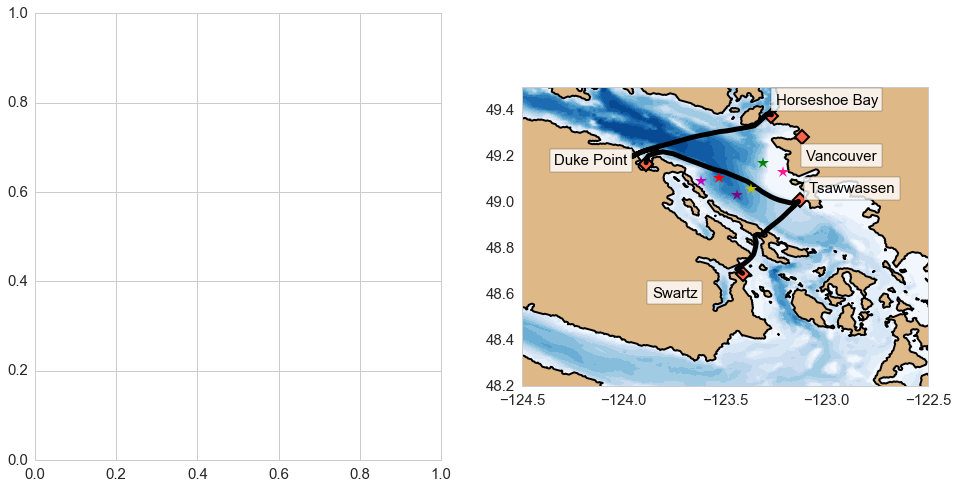

In [6]:
fig = salinity_ferry_route(bathy, PNW_coastline)

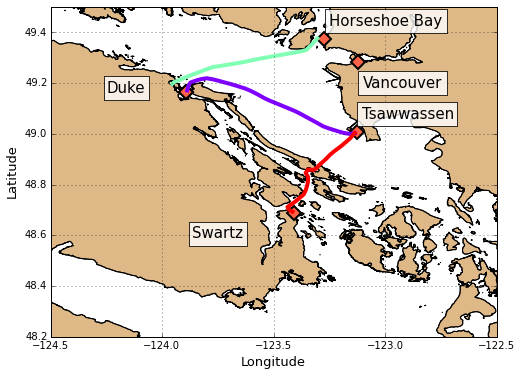

In [5]:
fig = salinity_ferry_route(bathy, PNW_coastline)

In [6]:
fig.savefig('ferryroute.png')